# CASO DE NEGOCIO: Modelamiento de Retención de Clientes en Scholastic Travel Company

## Sinopsis

Scholastic Travel Company (STC) quiere usar los datos de sus clientes para predecir quién comprará un paquete de viaje el próximo año. Los casos presentan datos de 2.389 clientes, donde el conjunto A contiene varios campos de perfil y el conjunto B contiene información adicional del Net Promoted Score (NPS)

Este notebook ha sido preparado con información provista en el Caso de Negocios de Harvard UV7579 (Agosto 23, 2018), Retention Modeling at Scholastic Travel Company, elaborado por Anton Ovchinnikov, profesor de Management Science, Operations Management y Customer Analytics, en la escuela de negocios Smith, de Queen’s University en Canadá.

Consideraremos varios modelos de analítica de datos:

1. MÁQUINAS DE VECTORES DE SOPORTE: un método intermedio entre las regresiones y los árboles que se ajusta a planos de menor dimensión para separar los datos en clases con el máximo margen entre ellas



# Preparación de los datos

In [1]:
# Cargar los paquetes y librerías necesarios 

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer

import warnings
warnings.filterwarnings("ignore")

# Cargar los datos desde el archivo CSV en el dataframe llamado df.
df = pd.read_csv("data_taller.csv", sep=";", header = 0)  

# Limpieza de datos -- parte 1: convertir tipos de datos incorrectos
df['From.Grade'] = df['From.Grade'].astype('category')
df['To.Grade'] = df['To.Grade'].astype('category')
df['Group.State'] = df['Group.State'].astype('category')
df['Is.Non.Annual.'] = df['Is.Non.Annual.'].astype('category')
df['Travel.Type'] = df['Travel.Type'].astype('category')
df['Poverty.Code'] = df['Poverty.Code'].astype('category')
df['CRM.Segment'] = df['CRM.Segment'].astype('category')
df['School.Type'] = df['School.Type'].astype('category')
df['Parent.Meeting.Flag'] = df['Parent.Meeting.Flag'].astype('category')
df['MDR.Low.Grade'] = df['MDR.Low.Grade'].astype('category')
df['MDR.High.Grade'] = df['MDR.High.Grade'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
df['SchoolGradeTypeLow'] = df['SchoolGradeTypeLow'].astype('category')
df['SchoolGradeTypeHigh'] = df['SchoolGradeTypeHigh'].astype('category')
df['GroupGradeTypeLow'] = df['GroupGradeTypeLow'].astype('category')
df['GroupGradeTypeHigh'] = df['GroupGradeTypeHigh'].astype('category')
df['MajorProgramCode'] = df['MajorProgramCode'].astype('category')
df['SingleGradeTripFlag'] = df['SingleGradeTripFlag'].astype('category')
df['SchoolSizeIndicator'] = df['SchoolSizeIndicator'].astype('category')
df['Retained.in.2012.'] = df['Retained.in.2012.'].astype('category')

df['Region'] = df['Region'].astype('category')
df['Special.Pay'] = df['Special.Pay'].astype('category')
df['Income.Level'] = df['Income.Level'].astype('category')
df['SPR.Product.Type'] = df['SPR.Product.Type'].astype('category')
df['SPR.New.Existing'] = df['SPR.New.Existing'].astype('category')

# Presentamos una función personalizada que llamaremos CombineRareCategories
# esta función tiene dos argumentos: el nombre del dataframe (data) y el número mínimo de puntos de datos para seguir 
# siendo una categoría separada (mincount)
# esta función recorrerá todas las columnas del marco de datos y combinará todas las categorías que aparezcan en los 
# datos menos que el número mínimo de veces en (Other)

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

# Aplicamos esta función a variables con mincount=10                    
CombineRareCategories(df, 10)
# Reemplazo/Imputación de datos faltantes
pd.DataFrame(df).isna().sum() # Chequeamos si hay datos faltantes  

# Método:
# Variables Categóricas: agregar una nueva categoría 'missing_value' (como si fuera un nuevo color, o género)
# Variables Numéricas: reemplazar con la mediana (o la media, o el valor más frecuente, etc.) Un método alterno es
# ejecutar una imputación, see here: https://scikit-learn.org/stable/modules/impute.html 
# + agregamos columnas sustitutas indicando que el valor ha sido imputado

# creación de variables sustitutas
for col in df:
    if df[col].isna().sum() != 0: 
        df[col + '_surrogate'] = df[col].isna().astype(int)

# fijación de variables categóricas
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# fijación de variables numéricas 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))

# Creación de dummies para variables no numéricas ("one hot encoding")
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)
pd.options.display.max_columns = None # remove the limit on the number of columns by default only 20 are shows

# Definición de X y Y
y = df['Retained.in.2012._1']
X = df.drop(columns = 'Retained.in.2012._1')
# Definimos la semilla para el generador de número aleatorios
np.random.seed(77300)

# Dividimos los datos aleatoriamente en 80% para entrenamiento y 20% para prueba 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Modelo SVM

In [ ]:
# Desarrollamos un clasificador SVM LINEAL
clfl = svm.SVC(kernel='linear', C=1, probability=True, random_state=1234) # Linear Kernel

# Entrenamos el modelo usando el dataset de entrenamiento
clfl.fit(X_train, y_train)

# Importamos el módulo scikit-learn metrics para cálculo de Accuracy
from sklearn import metrics
#Pronosticamos la respuesta para el dataset de prueba
#En entrenamiento
y_pred_t = clfl.predict(X_train)
#En prueba
y_pred = clfl.predict(X_test)

#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy SVM - entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy SVM - prueba: ",metrics.accuracy_score(y_test, y_pred))

Accuracy SVM - entrenamiento:  0.8273155416012559
Accuracy SVM - prueba:  0.805439330543933


# Modelo con Red Neuronal

In [ ]:
#librerías y paquetes
import tensorflow as tf
from tensorflow import keras
!pip install -q -U keras-tuner
import numpy as np 
import pandas as pd
import keras_tuner as tk # instalar por cmd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import to_categorical
from matplotlib import pyplot

     |████████████████████████████████| 135 kB 42.4 MB/s 
     |████████████████████████████████| 1.6 MB 73.5 MB/s 


In [ ]:
# Función para probar hiperparámetros

def model_builder(hp):
    
  hp_activation = hp.Choice('activation', values=['relu', 'tanh','linear','sigmoid'])
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=50)
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=50)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
 
  model = Sequential()
  model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation,input_dim=241))
  model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
  model.add(Dense(1, activation='sigmoid',use_bias=False))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mean_squared_error',metrics=['accuracy'])
  
  return model


# Algoritmo Hyperband

tuner = tk.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=5,directory='/notebooks/Documents/NOTEBOOKS/RNCLASS-HP6',
                     project_name='RNCLASS-HP6')

# crieterio de parada anticipada
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Búsqueda
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early],verbose=True)
best_model = tuner.get_best_models()[0]
#Resúmen
tuner.search_space_summary()
# Resúmen mejores parámetros
tuner.results_summary()



Trial 59 Complete [00h 00m 03s]
val_accuracy: 0.8158996105194092

Best val_accuracy So Far: 0.8179916143417358
Total elapsed time: 00h 02m 38s
Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'sigmoid'], 'ordered': False}
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 50, 'sampling': None}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 1000, 'step': 50, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Results summary
Results in /notebooks/Documents/NOTEBOOKS/RNCLASS-HP6/RNCLASS-HP6
Showing 10 best trials
Trial summary
Hyperparameters:
activation: tanh
layer_1: 951
layer_2: 851
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8179916143417358
Trial summary
Hyperparameters:
activation: t

In [ ]:
# Construcción del MODELO FINAL

"""
activation: linear
layer_1: 701
layer_2: 251
learning_rate: 0.0001
"""
model1 = Sequential()
   
model1.add(tf.keras.layers.Dense(units=701, activation="linear",input_dim=241))
model1.add(tf.keras.layers.Dense(units=251, activation="linear"))
model1.add(Dense(1, activation='sigmoid',use_bias=False))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['accuracy'])
model1.fit(X_train,y_train,epochs=200)
print(model1.summary())

#Pronosticamos la respuesta para el dataset de prueba
#En entrenamiento
y_pred_t = model1.predict(X_train)
#En prueba
y_pred = model1.predict(X_test)

class_threshold = 0.5
y_pred_t = np.where(y_pred_t > class_threshold, 1, 0) # clasificación
y_pred = np.where(y_pred > class_threshold, 1, 0) # clasificación


#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy  NN- entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy NN - prueba: ",metrics.accuracy_score(y_test, y_pred))

Epoch 1/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1810 - accuracy: 0.7405
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1512 - accuracy: 0.7907
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.8132
Epoch 4/200
60/60 [==============================] - 0s 4ms/step - loss: 0.1390 - accuracy: 0.8195
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.8189
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.8121
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.8226
Epoch 8/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1330 - accuracy: 0.8216
Epoch 9/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1338 - accuracy: 0.8153
Epoch 10/200
60/60 [==============================] - 0s 3ms/step - loss: 0.1316 - accuracy: 0.8237
Epoch 11/

# Modelo con árbol de decisión

Accuracy  Arbol Decision- entrenamiento:  0.8116169544740973
Accuracy Arbol Decision - prueba:  0.7949790794979079


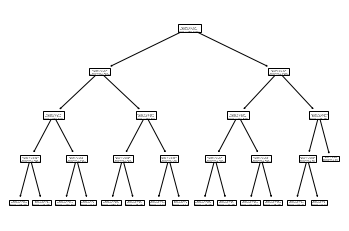

In [ ]:
#costruyendo un arbol de decisión para clasificación

from sklearn import tree
tree_model= tree.DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=4,min_samples_split=15,min_samples_leaf=5,random_state=123)                             
tree_model = tree_model.fit(X_train, y_train)
tree.plot_tree(tree_model)

#Realizando las pruebas
#En entrenamiento
y_pred_t = tree_model.predict(X_train)
#En prueba
y_pred = tree_model.predict(X_test)

#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy  Arbol Decision- entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy Arbol Decision - prueba: ",metrics.accuracy_score(y_test, y_pred))

# Modelos con Random Forest

In [ ]:
# Usando RANDOM FOREST - Modelo 1

from sklearn.ensemble import RandomForestClassifier
RF1 = RandomForestClassifier(n_estimators=30, max_features=200,bootstrap=True, oob_score=False, max_samples=150,random_state=123)
RF1.fit(X_train,y_train)
#Realizando las pruebas
#En entrenamiento
y_pred_t = RF1.predict(X_train)
#En prueba
y_pred = RF1.predict(X_test)

#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy  RF1- entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy RF1 - prueba: ",metrics.accuracy_score(y_test, y_pred))

#-----------------------------------------------------------------------------------------

# Usando RANDOM FOREST - Modelo 2

from sklearn.ensemble import RandomForestClassifier
RF2 = RandomForestClassifier(n_estimators=100, max_features=200,bootstrap=True, oob_score=False, max_samples=150,random_state=123)
RF2.fit(X_train,y_train)
#Realizando las pruebas
#En entrenamiento
y_pred_t = RF2.predict(X_train)
#En prueba
y_pred = RF2.predict(X_test)

#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy  RF2- entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy RF2 - prueba: ",metrics.accuracy_score(y_test, y_pred))

#-----------------------------------------------------------------------------------------

# Usando RANDOM FOREST - Modelo 3

from sklearn.ensemble import RandomForestClassifier
RF3 = RandomForestClassifier(criterion = "gini",min_samples_split=20,min_samples_leaf=10,n_estimators=80, max_features=40,bootstrap=False, oob_score=False,random_state=123)
RF3.fit(X_train,y_train)
#Realizando las pruebas
#En entrenamiento
y_pred_t = RF3.predict(X_train)
#En prueba
y_pred = RF3.predict(X_test)

#Accuracy del modelo:  Qué tan frecuentemente el clasificador es correcto?
#En entrenamiento: 
print("Accuracy  RF3- entrenamiento: ",metrics.accuracy_score(y_train, y_pred_t))
#En prueba: 
print("Accuracy RF3 - prueba: ",metrics.accuracy_score(y_test, y_pred))

Accuracy  RF1- entrenamiento:  0.8210361067503925
Accuracy RF1 - prueba:  0.7887029288702929
Accuracy  RF2- entrenamiento:  0.8246991104133962
Accuracy RF2 - prueba:  0.7949790794979079
Accuracy  RF3- entrenamiento:  0.913134484563056
Accuracy RF3 - prueba:  0.8117154811715481


#Boosting


In [2]:
# Modelo ADABOOST1

from sklearn.ensemble import AdaBoostClassifier

ada_model1 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=0)
ada_model1.fit(X_train, y_train)

ypredtra=ada_model1.predict(X_train)

ypredtes=ada_model1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra
                           ))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[ 531  219]
 [ 135 1026]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       750
           1       0.82      0.88      0.85      1161

    accuracy                           0.81      1911
   macro avg       0.81      0.80      0.80      1911
weighted avg       0.81      0.81      0.81      1911

[[129  59]
 [ 34 256]]
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       188
           1       0.81      0.88      0.85       290

    accuracy                           0.81       478
   macro avg       0.80      0.78      0.79       478
weighted avg       0.80      0.81      0.80       478



In [16]:
# Modelo ADABOOST2

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

base_model= LogisticRegression()
base_model1= SVC()

ada_model1 = AdaBoostClassifier(base_estimator=base_model1, n_estimators=200, learning_rate=0.1, random_state=0,algorithm='SAMME')
ada_model1.fit(X_train, y_train)

ypredtra=ada_model1.predict(X_train)

ypredtes=ada_model1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra
                           ))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[   0  750]
 [   0 1161]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       750
           1       0.61      1.00      0.76      1161

    accuracy                           0.61      1911
   macro avg       0.30      0.50      0.38      1911
weighted avg       0.37      0.61      0.46      1911

[[  0 188]
 [  0 290]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.61      1.00      0.76       290

    accuracy                           0.61       478
   macro avg       0.30      0.50      0.38       478
weighted avg       0.37      0.61      0.46       478



In [5]:
ada_modell1 = AdaBoostClassifier(base_estimator=base_model, n_estimators=100, learning_rate=0.1, random_state=0)
ada_modell1.fit(X_train, y_train)

ypredtra=ada_modell1.predict(X_train)

ypredtes=ada_modell1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra
                           ))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[ 495  255]
 [ 151 1010]]
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       750
           1       0.80      0.87      0.83      1161

    accuracy                           0.79      1911
   macro avg       0.78      0.76      0.77      1911
weighted avg       0.79      0.79      0.78      1911

[[125  63]
 [ 34 256]]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       188
           1       0.80      0.88      0.84       290

    accuracy                           0.80       478
   macro avg       0.79      0.77      0.78       478
weighted avg       0.80      0.80      0.79       478



In [12]:
# Modelo Gradientboost #1

from sklearn.ensemble import GradientBoostingClassifier

boost_model1 = GradientBoostingClassifier(n_estimators=100,random_state=42)
boost_model1.fit(X_train, y_train)

ypredtra=boost_model1.predict(X_train)

ypredtes=boost_model1.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra
                           ))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[ 601  149]
 [  85 1076]]
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       750
           1       0.88      0.93      0.90      1161

    accuracy                           0.88      1911
   macro avg       0.88      0.86      0.87      1911
weighted avg       0.88      0.88      0.88      1911

[[138  50]
 [ 39 251]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       188
           1       0.83      0.87      0.85       290

    accuracy                           0.81       478
   macro avg       0.81      0.80      0.80       478
weighted avg       0.81      0.81      0.81       478



In [15]:
# Modelo XGboost #1

# Instalar por consola
# pip install xgboost
# conda install xgboost

from xgboost import XGBClassifier

xgb_model1 = XGBClassifier(n_estimators=150, learning_rate=0.1, random_state=42)
xgb_model1.fit(X_train, y_train)

ypredtra=xgb_model1.predict(X_train)

ypredtes=xgb_model1.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra
                           ))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[ 616  134]
 [  71 1090]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       750
           1       0.89      0.94      0.91      1161

    accuracy                           0.89      1911
   macro avg       0.89      0.88      0.89      1911
weighted avg       0.89      0.89      0.89      1911

[[135  53]
 [ 39 251]]
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       188
           1       0.83      0.87      0.85       290

    accuracy                           0.81       478
   macro avg       0.80      0.79      0.80       478
weighted avg       0.81      0.81      0.81       478



In [9]:
# Definir un Stacking de modelos

from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

lista=[("lr",LogisticRegression()),("tree",DecisionTreeClassifier()),("svm",SVC())]
# se pueden usar todos los estimadores que se quieran y al final se asigna uno para dar como un filtro final   
model=StackingClassifier(estimators=lista,final_estimator=DecisionTreeClassifier())
model.fit(X_train, y_train)

ypredtra=model.predict(X_train)

ypredtes=model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_train,ypredtra))
print(classification_report(y_train,ypredtra))
print(confusion_matrix(y_test,ypredtes))
print(classification_report(y_test,ypredtes))

[[522 228]
 [215 946]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       750
           1       0.81      0.81      0.81      1161

    accuracy                           0.77      1911
   macro avg       0.76      0.76      0.76      1911
weighted avg       0.77      0.77      0.77      1911

[[112  76]
 [ 50 240]]
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       188
           1       0.76      0.83      0.79       290

    accuracy                           0.74       478
   macro avg       0.73      0.71      0.72       478
weighted avg       0.73      0.74      0.73       478



# Conclusiones
Como se puede observar tras utilizar el modelo con redes neuronales se presenta una mejora en el accuracy de entrenamiento llevandolo al 85,5% mientras que para el modelo de SVM se obtenia un 82,73%. Sin embargo, para el caso de prueba se observa un pequeño sobreajuste en el modelo de redes neuronales ya que el accuracy aquí disminuye al 79,49%, adicionalmente es menor al presentado por el modelo de SVM donde este es del 80,54%

Para el árbol de clasificación se mantuvieron las condiciones presentadas en la actividad con el dataset Iris. 
Sin embargo, para el caso de Random Forest se realizarón tres pruebas principales alterando los parametros del número de árboles, la cantidad de variables a utilizar y la decisión de utilizar o no a boostrap. Donde se obtuvo como mejor resultado el  uso de 80 árboles y 40 variables. 

Para el caso de Boosting, se observo que los modelos se fueron sobre ajustando cuando la cantidad de estimadores subia a más de 150, al igual que se observo un mejor funcionamiento con la tasa de aprendizaje de 0.1 para todos los modelos, finalmente cabe resaltar que las mejores métricas se obtuvieron con el algoritmo Gradientboost y las peores con ADABOOST usando como algoritmo SVM.